# Intro and Background

In 2018 I published a piece of software called MELODI - http://melodi.biocompute.org.uk/. Essentially it compares the text from two sets of publications and identifies common overlapping enriched terms based around a [PubMed](https://www.ncbi.nlm.nih.gov/pubmed/) search. I realised that a set of text could also be based on a person, making it possible to identify enriched terms for a person and common shared terms across two people. At the same time the JGI launched a competition to analyse the [University of Bristol's PURE data](https://research-information.bris.ac.uk) in a novel way, which I entered using some of the ideas from the MELODI work. This led to the production of AXON (http://axon.biocompute.org.uk/) and an AXON instance of the University of Bristol academic research output http://axon-bristol.biocompute.org.uk/. However, maintaining this and keeping it up-to-date was not feasible, as I am currently working at the Integrative Epidemiology Unit, and this is not really epidemiology. 

However, I think the ideas and (some of) the code might be of interest to others.


### Setup

Possibly the most important aspect of the data for this project is ensuring robust and unique identifiers. For individuals this can be achieved using ORCID identifiers (https://orcid.org/) and for publications we can use PubMed identifiers (https://www.ncbi.nlm.nih.gov/pubmed/).  

First, let's create some directories for data and output

In [27]:
import os
import config
os.makedirs('output',exist_ok=True)
os.makedirs('data',exist_ok=True)

Check python executable 

In [28]:
import sys
sys.executable

'/Users/be15516/anaconda3/envs/jgi-data-week-workshop/bin/python'

Result should be something like `/xxx/xxx/anaconda3/envs/jgi-data-week-workshop/bin/python`

### PubMed

PubMed (https://www.ncbi.nlm.nih.gov/pubmed/) comprises more than 29 million citations for biomedical literature from MEDLINE, life science journals, and online books. Citations may include links to full-text content from PubMed Central and publisher web sites.

We can use some simple commands to get PubMed data. First, let's import the pubmed function:

In [29]:
from scripts.pubmed_functions import get_pubmed_data_entrez

Using this, we can retrieve some data using a pubmed ID, e.g. 123

In [31]:
pubData=get_pubmed_data_entrez(['123'])

Read existing downloaded pubmed data from output/pubmed.tsv
-1 publications already downloaded
Processing ['123']


This has fetched some summary data for the publication with ID 123 and added it to a the file `output/pubmed.tsv`. 

Run it again, this time it will use local file

In [32]:
pubData=get_pubmed_data_entrez(['123'])

Read existing downloaded pubmed data from output/pubmed.tsv
1 publications already downloaded
123 is done
Nothing to do


### ORCID 

ORCID (https://orcid.org/) provides a persistent digital identifier that distinguishes you from every other researcher and, through integration in key research workflows such as manuscript and grant submission, supports automated linkages between you and your professional activities ensuring that your work is recognized. 

Let's get some info from an ORCID account

In [33]:
import requests

def get_ids_from_orcid_public_api(orcid):
    resp = requests.get("http://pub.orcid.org/"+orcid+"/works/", 
                        headers={'Accept':'application/orcid+json'})
    results = resp.json()
    pubData = []
    if 'group' in results:
        for i, result in enumerate( results['group']):
            pubDic={}
            if 'external-ids' in result:
                for e in result['external-ids']['external-id']:
                    if e['external-id-type']=='pmid':
                        pmid = e['external-id-value']
                        pubDic['pmid']=pmid
                    elif e['external-id-type']=='doi':
                        doi = e['external-id-value']
                        pubDic['doi']=doi
            if len(pubDic)>0:
                pubData.append(pubDic)
    else:
        print('no data found')
    return pubData

In [34]:
orcidData=get_ids_from_orcid_public_api('0000-0001-7328-4233')

In [35]:
print(orcidData)

[{'doi': '10.1038/s41467-019-08923-6'}, {'doi': '10.1038/s41598-018-26050-y'}, {'doi': '10.1093/ije/dyx251', 'pmid': '29342271'}, {'doi': '10.1093/nar/gkx1072', 'pmid': '29156009'}, {'doi': '10.1093/gigascience/gix035', 'pmid': '28486658'}, {'doi': '10.1101/118513'}, {'pmid': '27863423', 'doi': '10.18632/oncotarget.13387'}, {'pmid': '27663502'}, {'pmid': '25813983', 'doi': '10.1038/ncomms7548'}, {'doi': '10.1186/s13058-015-0593-0', 'pmid': '26070602'}, {'doi': '10.1093/bioinformatics/btt466', 'pmid': '23940251'}, {'pmid': '22281184', 'doi': '10.1186/1756-0500-5-68'}, {'doi': '10.1111/j.1365-3024.2011.01342.x', 'pmid': '22044053'}, {'doi': '10.1016/j.ijpara.2011.03.009', 'pmid': '21550347'}, {'doi': '10.1126/science.1147046', 'pmid': '18174420'}, {'doi': '10.1098/rsbl.2003.0130', 'pmid': '15252980'}]


From this dictionary we can easily get both PubMed IDs and DOIs

In [36]:
pubMedIDs = set()
doiIDs = set()
for i in orcidData:
    if 'pmid' in i:
        pubMedIDs.add(i['pmid'])
    if 'doi' in i:
        doiIDs.add(i['doi'])
print(len(pubMedIDs),'PMIDs')
print(len(doiIDs),'DOIs')

13 PMIDs
15 DOIs


Then using the same function as before we can get the PubMed data using the PubMed IDs:

In [37]:
#get the publication data using the PMIDs
pubData1=get_pubmed_data_entrez(list(pubMedIDs))
print(len(pubData1),'publication records returned')

Read existing downloaded pubmed data from output/pubmed.tsv
1 publications already downloaded
Processing ['27663502', '22044053', '18174420', '15252980', '29342271', '23940251', '21550347', '25813983', '29156009', '22281184', '27863423', '28486658', '26070602']
No DateCompleted
13 publication records returned


Often, a record in an ORCID account will not contain a PubMed identifier. In this case we can convert DOIs to PMIDs using and ID converter API - https://www.ncbi.nlm.nih.gov/pmc/tools/id-converter-api/

In [38]:
from scripts.pubmed_functions import doi_to_pmid
doi_pmid=doi_to_pmid(list(doiIDs))

In [39]:
print(doi_pmid)

['18174420', '29777112', '26070602', '30837455', '29342271', '23940251', '22281184', '29156009', '27863423', '28486658', '15252980']


Now we can create a single list of PMIDs and get all publication data

In [40]:
allPMIDs = list(set(list(pubMedIDs)+list(doi_pmid)))

In [41]:
pubData2=get_pubmed_data_entrez(allPMIDs)
print(len(pubData2),'publication records returned')

Read existing downloaded pubmed data from output/pubmed.tsv
14 publications already downloaded
27663502 is done
22044053 is done
18174420 is done
26070602 is done
29342271 is done
23940251 is done
21550347 is done
29156009 is done
22281184 is done
27863423 is done
25813983 is done
28486658 is done
15252980 is done
Processing ['29777112', '30837455']
No DateCompleted
15 publication records returned


We can wrap all this up, in a single function, to go from ORCID to PubMed data:

In [42]:
from scripts.common_functions import orcid_to_pubmedData

pubData=orcid_to_pubmedData(['0000-0001-7328-4233','0000-0003-0924-3247'])

1 Getting ORCID data for 0000-0001-7328-4233
13 PMIDs
15 DOIs
Read existing downloaded pubmed data from output/pubmed.tsv
16 publications already downloaded
27663502 is done
22044053 is done
18174420 is done
26070602 is done
29777112 is done
29342271 is done
30837455 is done
23940251 is done
21550347 is done
29156009 is done
22281184 is done
27863423 is done
25813983 is done
28486658 is done
15252980 is done
Nothing to do
2 Getting ORCID data for 0000-0003-0924-3247
107 PMIDs
161 DOIs
Read existing downloaded pubmed data from output/pubmed.tsv
16 publications already downloaded
27663502 is done
29342271 is done
Processing ['22325160', '26367797', '26889969', '23505291', '28137713', '27128317', '25262344', '22433445', '29025028', '29237687', '30707692', '25855720', '23620363', '25484485', '29162179', '27922636', '17980034', '25799584', '27114411', '23977022', '22253814', '26758643', '24345515', '30220325', '26833098', '22977227', '26095709', '27225428', '27040690', '28002404', '21455730

In [43]:
print(len(pubData))

136


### A 'real life' data set

As mentioned above, the key is to generate a robust set of individual/group IDs to text. ORCID is one option, but really we need to automatically create ORCID data for a large group. 

The University of Bristol uses the PURE architecture for housing and distributing research material. As part of this, users can add their ORCID IDs. For example - https://research-information.bristol.ac.uk/en/persons/benjamin-l-elsworth(b4014828-88e9-4861-ae1d-5c369b6ae35a).html

Extracting the ORCID ID from here is fairly simple:

In [44]:
import requests
import re

url = 'https://research-information.bristol.ac.uk/en/persons/benjamin-l-elsworth(b4014828-88e9-4861-ae1d-5c369b6ae35a).html'
res = requests.get(url)
orcid = re.findall('orcid.org/(.*?)".*', res.text)
print('orcid',orcid)


orcid ['0000-0001-7328-4233']


Wonderful, but what is that strange ID in the URL above - **b4014828-88e9-4861-ae1d-5c369b6ae35a** ?

These are actually the PURE identifiers for each person at the University. So, if we go to the persons page (https://research-information.bristol.ac.uk/en/persons/search.html) we can, in theory, get these for everyone at the University. 

In [45]:
import requests
import re

url = 'http://research-information.bristol.ac.uk/en/persons/search.html?filter=academic&page=1&pageSize=10'
res = requests.get(url)
pDic={}
uuid = re.findall('persons/(.*?)\((.*?)\).html', res.text)
#print(uuid)
for u in uuid:
    name = u[0].replace('-',' ').title()
    uuid = u[1]
    pDic[uuid]=name
for p in pDic:
    print(p,pDic[p])

e56cc335-3cbf-4b24-aca1-21d9ead1004d Byron Adams
4803d085-611f-4365-99cb-cbdf7ede80c0 Chris J Adams
182d22e2-d9a2-4b95-9cf0-5ce91da1266f Josephine C Adams
a6d8796d-4ecf-43a9-bba8-66a8595d3bc9 Jeremy Adcock
9e4f879b-4f8f-4ae8-a5a0-f86aa750e0b4 Martin Addy
045d849f-a6d0-4e4c-be02-517c320c9a97 Foluke I Adebisi
834a45cf-8319-4cd0-829a-5a1c9be678cc A E Ades
8b156807-c78e-4cd6-98fa-26e873ff4b78 Marco Adinolfi
67d038ce-752b-44ff-99bc-bd1eac103147 Marinella Afshin
d29e7842-e9a3-4826-bfa5-37105cef192d Maryam Afzal


Now, this kind of scraping is not ideal, but is effective. To save time, and getting in troule with the PURE team at the University, we've extracted data for all academics with a listed ORCID. This includes the following:

| Description | File | 
| --- |---|
| PURE Person UUID and Person Name | [data/pure_people.txt](data/pure_people.txt) | 
| PURE Person UUID and ORCID ID | [data/pure_person_to_orcid.txt](data/pure_person_to_orcid.txt) |
| PURE Person UUID and Organisation UUID | [data/pure_person_to_org.txt](data/pure_person_to_org.txt) |
| PURE Organisation UUID and Organisation Name | [data/pure_org_to_name.txt](data/pure_org_to_name.txt) |
 
From here we can start looking at enriched terms for each person and organisation.

## QC

So far, we haven't really checked any of the data. This is something we should do as everything downstream will be affected by the data at this point. One thing we can do, is look at the publication text.

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

pubmedToInfo = pd.read_csv('data/pubmed.tsv',sep='\t')
print(pubmedToInfo.shape)
print(pubmedToInfo.head())

(11160, 4)
       pmid  year                                              title  \
0  25475436  2015  Sixty-five common genetic variants and predict...   
1  25011450  2014  Association between alcohol and cardiovascular...   
2  28968714  2018  FATHMM-XF: accurate prediction of pathogenic p...   
3  21965548  2012  Four genetic loci influencing electrocardiogra...   
4  26930047  2016  Diagnosis of Coronary Heart Diseases Using Gen...   

                                            abstract  
0  We developed a 65 type 2 diabetes (T2D) varian...  
1  To use the rs1229984 variant in the alcohol de...  
2  We present FATHMM-XF, a method for predicting ...  
3  Presence of left ventricular hypertrophy on an...  
4  Cardiovascular disease (including coronary art...  


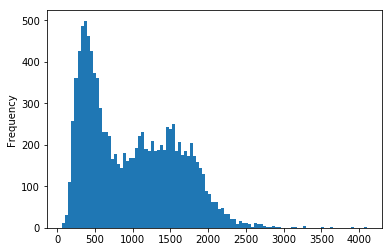

In [47]:
textData=pubmedToInfo['title'].str.len()+pubmedToInfo['abstract'].str.len()
textData.plot.hist(bins = 100)

Perhaps we should remove publications with very short title+abstract?

In [48]:
(textData<50).value_counts()

False    11160
dtype: int64

It seems that all title+abstract are > 50 characters, so we will keep them all.

We can also look at the distribution of publication year, exluding 0 (as that was included to cover missing data)

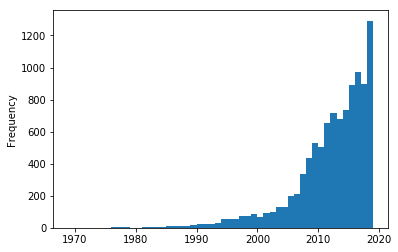

In [49]:
pubYearData=pubmedToInfo[pubmedToInfo['year']>0]['year']
pubYearData.plot.hist(bins = 50)

Lastly, numbers of publication per person:

In [50]:
#ORCID to PubMed identifiers
orcidToPubmed = pd.read_csv('data/orcid.tsv',sep='\t')
print(orcidToPubmed.shape)
print(orcidToPubmed.head())

(15722, 2)
              orcid_id      pmid
0  0000-0001-5001-3350  26961927
1  0000-0001-5001-3350  30605491
2  0000-0001-5008-0705  29118635
3  0000-0001-5017-9473  18194108
4  0000-0001-5017-9473  18607707


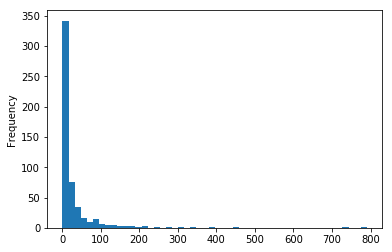

In [51]:
orcidToPubmed['orcid_id'].value_counts().plot.hist(bins = 50)

There are a no people with zero publications from their ORCID accounts, so no need to filter.

In [52]:
(orcidToPubmed['orcid_id'].value_counts()==0).sum()

0